In [1]:
from time import time
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


from PIL import Image
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import fetch_lfw_pairs

In [2]:
lfw_dataset_train = fetch_lfw_pairs(subset='train', resize=0.4)
lfw_dataset_test = fetch_lfw_pairs(subset='test',resize=0.4)

In [3]:
lfw_dataset_test.keys()

dict_keys(['data', 'pairs', 'target', 'target_names', 'DESCR'])

In [4]:
X_train = lfw_dataset_train.data
y_train = lfw_dataset_train.target

X_test = lfw_dataset_test.data
y_test = lfw_dataset_test.target

In [5]:
def prepare_dataset(lfw_dataset):
    cnn_data = []
    cnn_data_1 = []
    cnn_data_2 = []
    for images_paris in lfw_dataset['pairs']:
        image1 = images_paris[0]
        image2 = images_paris[1]
        # Stack the two images along the channel axis to create a single image 
        # with dimensions (32, 32, 6)
        combined_image = np.concatenate((image1, image2), axis=0)
        # combined_image = combined_image[:, :, :3]
        cnn_data_1.append(image1)
        cnn_data_2.append(image2)
        cnn_data.append(combined_image)
    cnn_data  = np.stack(cnn_data, axis=0)
    cnn_data_1  = np.stack(cnn_data_1, axis=0)
    cnn_data_2  = np.stack(cnn_data_2, axis=0)
    
    return cnn_data, cnn_data_1, cnn_data_2


cnn_train_data, cnn_train_data_1, cnn_train_data_2 = prepare_dataset(lfw_dataset_train)
cnn_test_data, cnn_test_data_1, cnn_test_data_2 = prepare_dataset(lfw_dataset_test)

In [6]:
cnn_train_data_2.shape, cnn_train_data_1.shape

((2200, 50, 37), (2200, 50, 37))

In [7]:
cnn_test_data_1.shape, cnn_test_data_2.shape

((1000, 50, 37), (1000, 50, 37))

In [8]:
### passing the single image to the function to check the result
X_train_1 = []
for image in cnn_train_data_1:
    X_train_1.append(image.flatten())
X_train_1 = np.array(X_train_1)

X_train_2 = []
for image in cnn_train_data_2:
    X_train_2.append(image.flatten())
X_train_2 = np.array(X_train_2)

In [9]:
X_train_1.shape, X_train_2.shape

((2200, 1850), (2200, 1850))

In [10]:
### passing the single image to the function to check the result
X_test_1 = []

for image in cnn_test_data_1:
    X_test_1.append(image.flatten())
X_test_1 = np.array(X_test_1)

X_test_2 = []
for image in cnn_test_data_2:
    X_test_2.append(image.flatten())
X_test_2 = np.array(X_test_2)

In [11]:
X_test_1.shape, X_test_2.shape

((1000, 1850), (1000, 1850))

In [63]:
def pca_implementation(X_train, X_test):
    # Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
    # dataset): unsupervised feature extraction / dimensionality reduction
    n_components = 125

    print("Extracting the top %d eigenfaces from %d faces"
          % (n_components, X_train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',
              whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))

    eigenfaces = pca.components_.reshape((n_components, 50, 37))

    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("done in %0.3fs" % (time() - t0))
    return X_train_pca, X_test_pca, eigenfaces
   

In [64]:
X_train_pca_1, X_test_pca_1, eigenfaces = pca_implementation(X_train_1, X_test_1)

Extracting the top 125 eigenfaces from 2200 faces
done in 1.255s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.049s


In [65]:
X_train_pca_2, X_test_pca_2, eigenfaces = pca_implementation(X_train_2, X_test_2)

Extracting the top 125 eigenfaces from 2200 faces
done in 1.079s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.047s


In [66]:
X_train_combined = np.hstack((X_train_pca_1,X_train_pca_2))

In [67]:
X_test_combined = np.hstack((X_test_pca_1,X_test_pca_2))

In [68]:
model = RandomForestClassifier(criterion = "log_loss")
model.fit(X_train_combined, y_train)

RandomForestClassifier(criterion='log_loss')

In [69]:
y_pred = model.predict(X_test_combined)

In [70]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.509


In [71]:
from sklearn.metrics import confusion_matrix, classification_report

target = lfw_dataset_test.target
target_names = lfw_dataset_test.target_names


print(classification_report(y_pred, y_test, target_names=target_names))

                   precision    recall  f1-score   support

Different persons       0.51      0.51      0.51       499
      Same person       0.51      0.51      0.51       501

         accuracy                           0.51      1000
        macro avg       0.51      0.51      0.51      1000
     weighted avg       0.51      0.51      0.51      1000



In [73]:
eigenfaces.shape

(125, 50, 37)

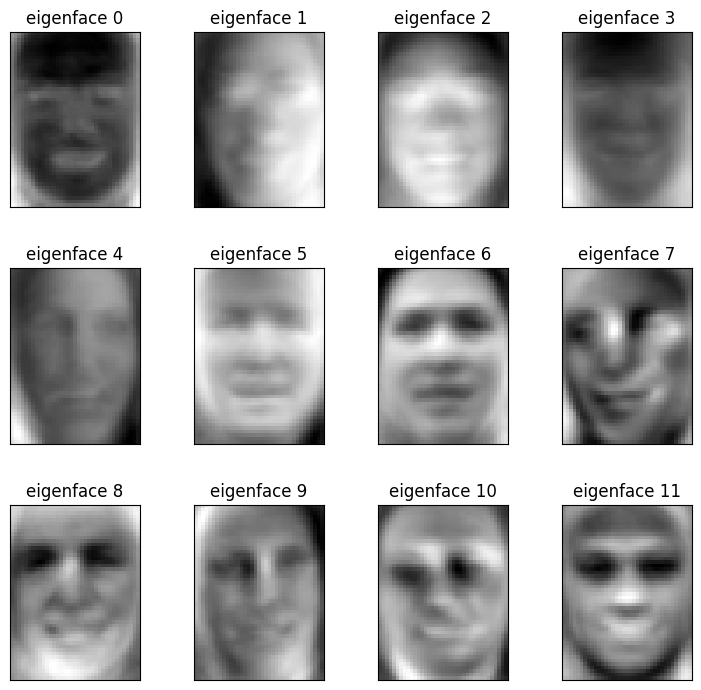

In [74]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((50, 37)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# # plot the result of the prediction on a portion of the test set
# def title(y_pred, y_test, target_names, i):
#     pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
#     true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
#     return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

# prediction_titles = [title(y_pred, y_test, target_names, i)
#                      for i in range(y_pred.shape[0])]

# plot_gallery(X_test, prediction_titles, 50, 37)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 50, 37)

plt.show()

In [84]:
import cv2

image = cnn_train_data_2[0]

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create()

# Find keypoints and descriptors
keypoints, descriptors = orb.detectAndCompute(gray_image, None)


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


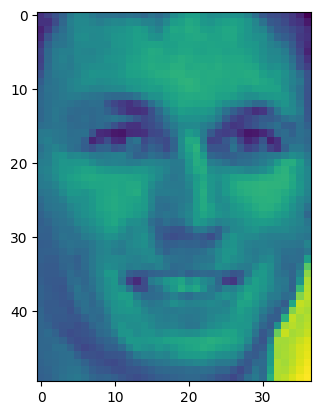

In [86]:
plt.imshow(image)

In [81]:
# Draw keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=0)

# Show the image with keypoints
cv2.imshow("ORB Keypoints", image_with_keypoints)
cv2.waitKey(0)
cv2.destroyAllWindows()

return keypoints, descriptors

Docstring:
detectAndCompute(image, mask[, descriptors[, useProvidedKeypoints]]) -> keypoints, descriptors
.   Detects keypoints and computes the descriptors
Type:      builtin_function_or_method